# For undersampled dataset

In [11]:
# libraries 

import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import cv2

import tensorflow as tf
import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns 

import pandas as pd 
import numpy as np
from PIL import Image

2023-07-14 13:51:14.734586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Variables 

In [12]:
# test, train and val directories
# train_directory = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/finalized_aptos/train/'
# val_directory = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/finalized_aptos/val/'
# test_directory = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/finalized_aptos/test/'

# train_directory = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/cropped_aptos/train'
# val_directory = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/cropped_aptos/val'
# test_directory ='/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/cropped_aptos/test'


In [26]:
train_directory = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/script/3_class/dataset/train/'
val_directory = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/script/3_class/dataset/val/'
test_directory = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/script/3_class/dataset/test/'

In [27]:
from skimage.transform import resize 

In [28]:
def pre_process(image):
    return cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 5) ,-4 ,128)


# Values

In [29]:
IMAGE_SIZE = 256
EPOCH = 20

In [30]:
def visualize_performance(history):
    #Visualizing the training performance
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='val_Loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    plt.title('Loss evolution')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy evolution')

# Image Pre-processing 

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
#     zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=pre_process
)

In [32]:

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=32,
     batch_size=32,
    class_mode='sparse',
#     color_mode='grayscale',
#     shuffle=True,
    seed=24
)


Found 2930 images belonging to 3 classes.


In [33]:
# Get the next batch of images and labels from the generator
images_temp, labels_temp = train_generator.next()

In [34]:
class_labels = list(train_generator.class_indices.keys())
class_labels

['NPDR', 'No_DR', 'PDR']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


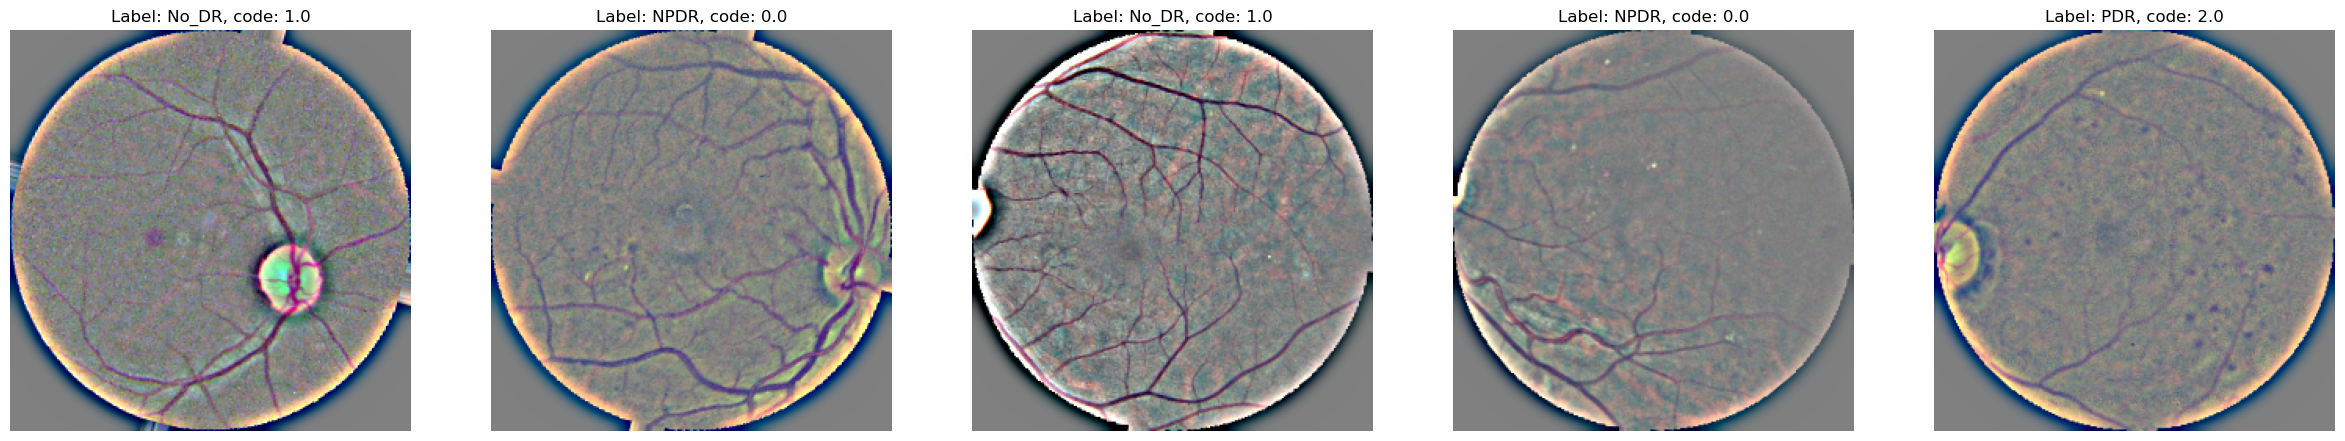

In [35]:

# Get the next batch of images and labels from the generator
images, labels = train_generator.next()

# Display the first 5 images from the batch
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 10))


for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title('Label: {}'.format(class_labels[int(labels[i])])+', code: {}'.format(labels[i]))
    ax.axis('off')

plt.show()

In [36]:
# for validation 
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=pre_process
)

In [37]:

validation_generator = validation_datagen.flow_from_directory(
    val_directory,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse',
#     color_mode='grayscale',
    shuffle=False,
    seed=24
)

Found 366 images belonging to 3 classes.


In [38]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=pre_process
)

In [39]:


test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse',
#     color_mode='grayscale',
    shuffle=False,
#     seed=24
)

Found 366 images belonging to 3 classes.


# Model creation

In [40]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, input_shape = (IMAGE_SIZE, IMAGE_SIZE,3), activation='relu'),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),

    
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(256, 3, activation='relu'),
    keras.layers.Conv2D(256, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation='relu'),

    keras.layers.Dense(128, activation='relu'),

        
    keras.layers.Dense(64, activation='relu'),

    
    keras.layers.Dense(5, activation='softmax')
    
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2023-07-14 13:52:46.504201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                    

In [42]:
from keras.callbacks import ReduceLROnPlateau


In [43]:
# hyper-parameters
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                              verbose=0, mode='auto', min_delta=0.0001,
                              cooldown=0, min_lr=0.00001)
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


In [44]:
model_h = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCH,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr,early_stopping]#,checkpoint]

)

Epoch 1/20
91/91 [==============================] - 1069s 12s/step - loss: 1.0590 - accuracy: 0.4838 - val_loss: 0.9526 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 2/20
91/91 [==============================] - 792s 9s/step - loss: 1.0207 - accuracy: 0.4762 - val_loss: 0.9206 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 3/20
91/91 [==============================] - 939s 10s/step - loss: 0.9367 - accuracy: 0.5804 - val_loss: 0.8463 - val_accuracy: 0.6676 - lr: 0.0010
Epoch 4/20
91/91 [==============================] - 1215s 13s/step - loss: 0.8410 - accuracy: 0.6529 - val_loss: 0.7092 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 5/20
91/91 [==============================] - 1467s 16s/step - loss: 0.7697 - accuracy: 0.6877 - val_loss: 0.6161 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 6/20
91/91 [==============================] - 2206s 24s/step - loss: 0.7491 - accuracy: 0.6977 - val_loss: 0.6460 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 7/20
91/91 [==============================] - 1813s 20s/step 

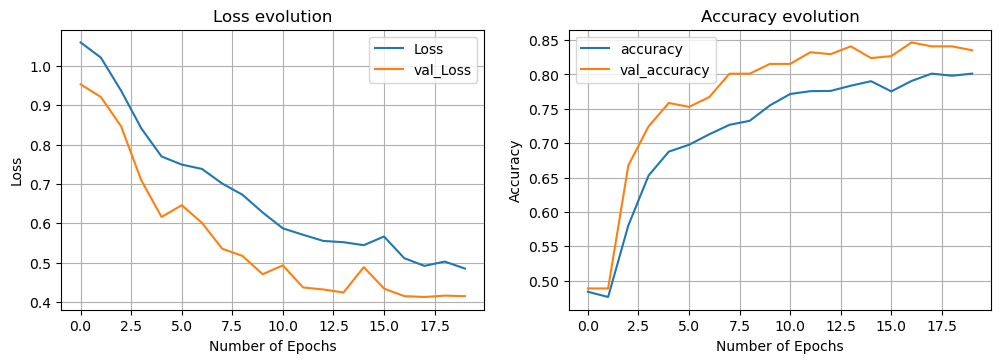

In [45]:
visualize_performance(model_h)

In [46]:
model.evaluate(test_generator)

12/12 [==============================] - 77s 6s/step - loss: 0.4832 - accuracy: 0.8033


[0.48324039578437805, 0.8032786846160889]

In [47]:
model_predictions = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
model_predictions

11/11 [==============================] - 79s 6s/step


array([[8.0309135e-01, 5.6477864e-03, 1.9126064e-01, 5.3612041e-08,
        1.4753194e-07],
       [7.5867385e-01, 1.2631529e-02, 2.2869298e-01, 4.3186020e-07,
        1.2126497e-06],
       [8.2836723e-01, 5.5819312e-03, 1.6605058e-01, 7.6346126e-08,
        1.7367375e-07],
       ...,
       [7.3762399e-01, 1.5105025e-02, 2.4726549e-01, 1.6705424e-06,
        3.8302383e-06],
       [7.5128561e-01, 1.4968738e-02, 2.3374222e-01, 9.4961695e-07,
        2.4367268e-06],
       [7.5218564e-01, 1.5096723e-02, 2.3271142e-01, 2.0653808e-06,
        4.2294519e-06]], dtype=float32)

In [48]:


model_predicted_classes = [np.argmax(pred) for pred in model_predictions]
model_predicted_classes[:5]


[0, 0, 0, 1, 0]

In [49]:
true_classes = test_generator.classes
true_classes[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [50]:
class_labels_test_data = list(test_generator.class_indices.keys())
class_labels_test_data

['NPDR', 'No_DR', 'PDR']

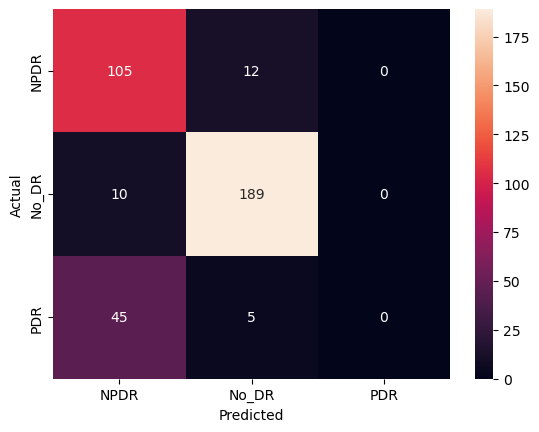

In [51]:
cm = confusion_matrix(true_classes, model_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_test_data, yticklabels= class_labels_test_data)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [52]:
report = classification_report(true_classes, model_predicted_classes, target_names=class_labels_test_data)
print(report) 

              precision    recall  f1-score   support

        NPDR       0.66      0.90      0.76       117
       No_DR       0.92      0.95      0.93       199
         PDR       0.00      0.00      0.00        50

    accuracy                           0.80       366
   macro avg       0.52      0.62      0.56       366
weighted avg       0.71      0.80      0.75       366



/Users/sudeshgurung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sudeshgurung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sudeshgurung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

# Pretrained model

## 1.Inception

In [53]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))




In [54]:
for layer in InceptionV3_model.layers:
    layer.trainable = False

In [56]:
inception_model = Sequential()
inception_model.add(InceptionV3_model)
# inception_model.add(Dropout(0.25))
inception_model.add(Flatten()),
inception_model.add(Dropout(0.25))
# model.add(Dense(1024, activation='relu'))
inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dense(64, activation='relu'))
inception_model.add(Dense(5, activation='softmax'))


In [57]:
inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [58]:
inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dropout_4 (Dropout)         (None, 73728)             0         
                                                                 
 dense_7 (Dense)             (None, 128)               9437312   
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 31,248,677
Trainable params: 9,445,893
N

In [59]:
inception_h = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCH,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/20
91/91 [==============================] - 938s 10s/step - loss: 2.6672 - accuracy: 0.6865 - val_loss: 0.7793 - val_accuracy: 0.7102 - lr: 0.0010
Epoch 2/20
91/91 [==============================] - 913s 10s/step - loss: 0.7862 - accuracy: 0.7726 - val_loss: 0.5192 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 3/20
91/91 [==============================] - 900s 10s/step - loss: 0.6788 - accuracy: 0.7692 - val_loss: 0.5889 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 4/20
91/91 [==============================] - 912s 10s/step - loss: 0.5709 - accuracy: 0.7940 - val_loss: 0.4328 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 5/20
91/91 [==============================] - 831s 9s/step - loss: 0.4852 - accuracy: 0.8137 - val_loss: 0.3888 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 6/20
91/91 [==============================] - 828s 9s/step - loss: 0.4623 - accuracy: 0.8254 - val_loss: 0.4000 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 7/20
91/91 [==============================] - 882s 10s/step - loss

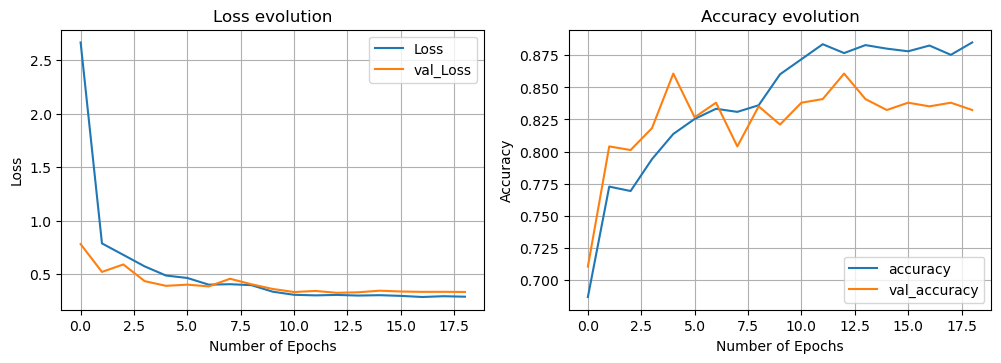

In [60]:
visualize_performance(inception_h)

In [61]:
inception_model.evaluate(test_generator)

12/12 [==============================] - 30s 2s/step - loss: 0.3877 - accuracy: 0.8361


[0.3877379894256592, 0.8360655903816223]

In [62]:
inception_predictions = inception_model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
inception_predictions

11/11 [==============================] - 30s 2s/step


array([[9.09425080e-01, 1.51226981e-04, 9.04236585e-02, 2.94187963e-09,
        9.15012201e-19],
       [8.44717503e-01, 2.12199688e-02, 1.34062544e-01, 1.30253728e-08,
        1.10460554e-16],
       [4.07042831e-01, 5.35167873e-01, 5.77881783e-02, 1.12002965e-06,
        3.01521960e-15],
       ...,
       [1.89129487e-01, 1.92430464e-03, 8.08946192e-01, 5.46832224e-09,
        2.23054474e-19],
       [8.88470531e-01, 1.18715877e-06, 1.11528322e-01, 1.57301172e-10,
        1.67998799e-20],
       [8.83275807e-01, 9.24914048e-07, 1.16723299e-01, 1.19918520e-10,
        2.26045455e-19]], dtype=float32)

In [63]:
inception_predicted_classes = [np.argmax(pred) for pred in inception_predictions]
inception_predicted_classes[:5]

[0, 0, 1, 0, 0]

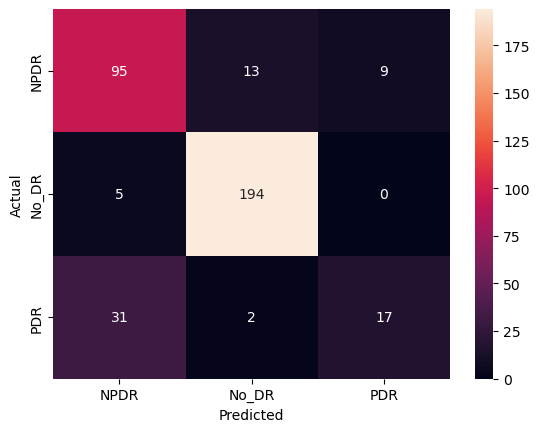

In [64]:
cm = confusion_matrix(true_classes, inception_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_test_data, yticklabels= class_labels_test_data)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [65]:
report = classification_report(true_classes, inception_predicted_classes, target_names=class_labels_test_data)
print(report) 

              precision    recall  f1-score   support

        NPDR       0.73      0.81      0.77       117
       No_DR       0.93      0.97      0.95       199
         PDR       0.65      0.34      0.45        50

    accuracy                           0.84       366
   macro avg       0.77      0.71      0.72       366
weighted avg       0.83      0.84      0.82       366



## 2.VGG


In [66]:
from tensorflow.keras.applications.vgg16 import VGG16

In [67]:
# pooling='avg',
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

In [68]:
for layers in vgg16_model.layers:
            layers.trainable=False

In [69]:
vgg16_final_model = Sequential()
vgg16_final_model.add(vgg16_model)
vgg16_final_model.add(Dropout(0.25))
vgg16_final_model.add(Flatten()),
vgg16_final_model.add(Dropout(0.25))
# model.add(Dense(1024, activation='relu'))
vgg16_final_model.add(Dense(128, activation='relu'))
vgg16_final_model.add(Dense(64, activation='relu'))
vgg16_final_model.add(Dense(5, activation='softmax'))


In [70]:
vgg16_final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [71]:
vgg16_final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 512)         0         
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_6 (Dropout)         (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               4194432   
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 5)                

In [72]:
vgg16_final_model_h = vgg16_final_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCH,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/20
91/91 [==============================] - 868s 10s/step - loss: 0.9364 - accuracy: 0.6950 - val_loss: 0.5515 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 2/20
91/91 [==============================] - 966s 11s/step - loss: 0.5377 - accuracy: 0.7823 - val_loss: 0.3760 - val_accuracy: 0.8494 - lr: 0.0010
Epoch 3/20
91/91 [==============================] - 862s 9s/step - loss: 0.4876 - accuracy: 0.8043 - val_loss: 0.3790 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 4/20
91/91 [==============================] - 866s 9s/step - loss: 0.4531 - accuracy: 0.8081 - val_loss: 0.4507 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 5/20
91/91 [==============================] - 949s 10s/step - loss: 0.3811 - accuracy: 0.8430 - val_loss: 0.3538 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 6/20
91/91 [==============================] - 876s 10s/step - loss: 0.3774 - accuracy: 0.8427 - val_loss: 0.3786 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 7/20
91/91 [==============================] - 860s 9s/step

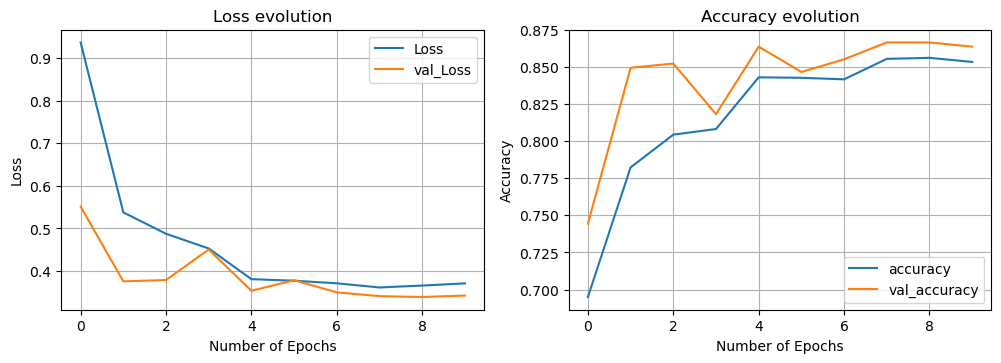

In [73]:
visualize_performance(vgg16_final_model_h)

In [74]:
vgg16_final_model.evaluate(test_generator)

12/12 [==============================] - 96s 8s/step - loss: 0.3620 - accuracy: 0.8525


[0.36197373270988464, 0.8524590134620667]

In [75]:
vgg16_predictions = vgg16_final_model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
vgg16_predictions

11/11 [==============================] - 95s 8s/step


array([[8.2740420e-01, 8.7438989e-03, 1.6385134e-01, 5.3927312e-07,
        2.0150337e-09],
       [7.2325206e-01, 2.5962817e-02, 2.5078407e-01, 1.0397154e-06,
        3.2413390e-09],
       [7.6974362e-01, 1.8616164e-01, 4.4093862e-02, 8.8555879e-07,
        2.2533999e-09],
       ...,
       [4.9675310e-01, 1.5874328e-04, 5.0308824e-01, 1.3998827e-08,
        1.7707662e-11],
       [7.2637749e-01, 3.3054221e-03, 2.7031678e-01, 3.5888570e-07,
        5.5927651e-10],
       [7.6159495e-01, 4.6697459e-03, 2.3373492e-01, 3.6172008e-07,
        6.0262044e-09]], dtype=float32)

In [76]:
vgg16_predicted_classes = [np.argmax(pred) for pred in vgg16_predictions]
vgg16_predicted_classes[:5]

[0, 0, 0, 0, 0]

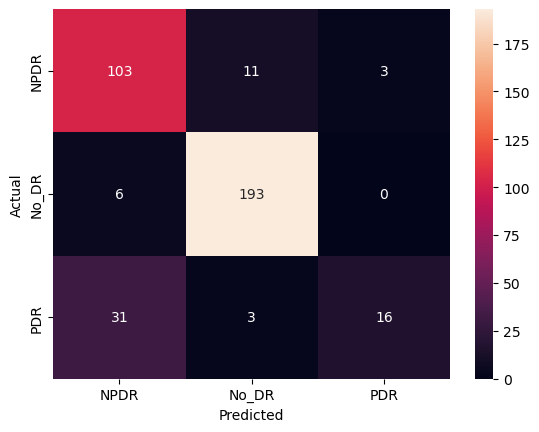

In [77]:
cm = confusion_matrix(true_classes, vgg16_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_test_data, yticklabels= class_labels_test_data)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [78]:
report = classification_report(true_classes, vgg16_predicted_classes, target_names=class_labels_test_data)
print(report) 

              precision    recall  f1-score   support

        NPDR       0.74      0.88      0.80       117
       No_DR       0.93      0.97      0.95       199
         PDR       0.84      0.32      0.46        50

    accuracy                           0.85       366
   macro avg       0.84      0.72      0.74       366
weighted avg       0.86      0.85      0.84       366



## 3. ResNet

In [79]:
# from tensorflow.python.keras.applications import ResNet50

In [80]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import resnet50

In [81]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))#, classes=6)

In [82]:
for layers in ResNet50_model.layers:
    layers.trainable=False

In [83]:
resNet50_model = Sequential()
resNet50_model.add(ResNet50_model)
resNet50_model.add(Dropout(0.25))
resNet50_model.add(Flatten()),
resNet50_model.add(Dropout(0.25))
resNet50_model.add(Dense(128, activation='relu'))
resNet50_model.add(Dense(64, activation='relu'))
resNet50_model.add(Dense(5, activation='softmax'))

In [84]:
resNet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [85]:
resNet50_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout_7 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_8 (Dropout)         (None, 131072)            0         
                                                                 
 dense_13 (Dense)            (None, 128)               16777344  
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 5)                

In [86]:
resNet50_h = resNet50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCH,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/20
91/91 [==============================] - 421s 5s/step - loss: 2.7119 - accuracy: 0.5035 - val_loss: 1.0905 - val_accuracy: 0.5256 - lr: 0.0010
Epoch 2/20
91/91 [==============================] - 409s 4s/step - loss: 0.8838 - accuracy: 0.6270 - val_loss: 0.7265 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 3/20
91/91 [==============================] - 438s 5s/step - loss: 0.8036 - accuracy: 0.6670 - val_loss: 0.8259 - val_accuracy: 0.6051 - lr: 0.0010
Epoch 4/20
91/91 [==============================] - 449s 5s/step - loss: 0.9035 - accuracy: 0.6197 - val_loss: 1.0690 - val_accuracy: 0.5227 - lr: 0.0010
Epoch 5/20
91/91 [==============================] - 454s 5s/step - loss: 0.7204 - accuracy: 0.7084 - val_loss: 0.6848 - val_accuracy: 0.7415 - lr: 1.0000e-04
Epoch 6/20
91/91 [==============================] - 450s 5s/step - loss: 0.7082 - accuracy: 0.7091 - val_loss: 0.7280 - val_accuracy: 0.7017 - lr: 1.0000e-04
Epoch 7/20
91/91 [==============================] - 452s 5s/step - l

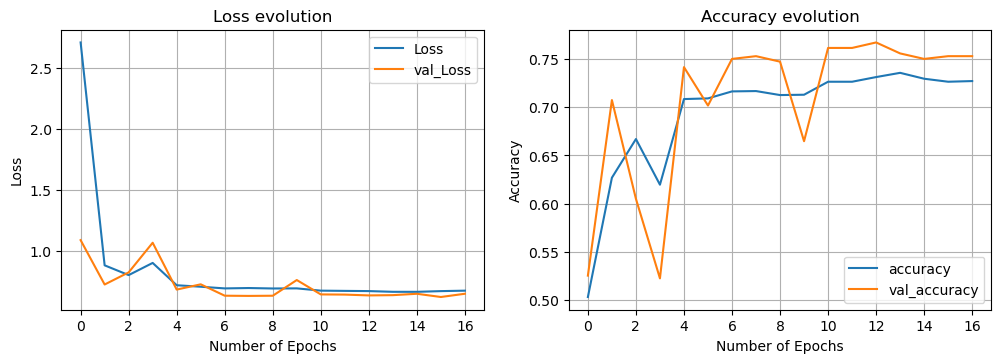

In [87]:
visualize_performance(resNet50_h)

In [88]:
resNet50_model.evaluate(test_generator)

12/12 [==============================] - 82s 7s/step - loss: 0.6471 - accuracy: 0.7240


[0.6470624804496765, 0.7240437269210815]

In [89]:
resNet50_predictions = resNet50_model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
resNet50_predictions

11/11 [==============================] - 84s 7s/step


array([[6.6999620e-01, 1.5259047e-01, 1.7740858e-01, 5.5767472e-08,
        4.6370765e-06],
       [7.0388275e-01, 7.7330656e-02, 2.1878335e-01, 1.0185255e-07,
        3.1462307e-06],
       [3.1322226e-01, 5.9347111e-01, 9.3263365e-02, 2.3045740e-08,
        4.3194592e-05],
       ...,
       [6.6750216e-01, 1.3927746e-01, 1.9321610e-01, 1.5791072e-08,
        4.2240290e-06],
       [6.4171058e-01, 1.3188462e-01, 2.2639990e-01, 7.3092046e-08,
        4.8741554e-06],
       [3.1489891e-01, 5.5378103e-01, 1.3130984e-01, 1.3158977e-08,
        1.0206452e-05]], dtype=float32)

In [90]:
resNet50_predicted_classes = [np.argmax(pred) for pred in resNet50_predictions]
resNet50_predicted_classes[:5]

[0, 0, 1, 1, 0]

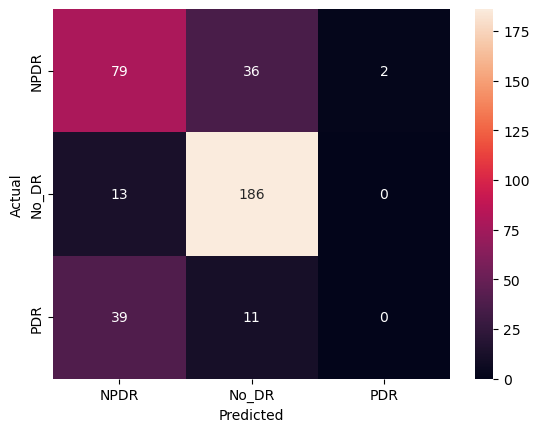

In [91]:
cm = confusion_matrix(true_classes, resNet50_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_test_data, yticklabels= class_labels_test_data)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [92]:
report = classification_report(true_classes, resNet50_predicted_classes, target_names=class_labels_test_data)
print(report) 

              precision    recall  f1-score   support

        NPDR       0.60      0.68      0.64       117
       No_DR       0.80      0.93      0.86       199
         PDR       0.00      0.00      0.00        50

    accuracy                           0.72       366
   macro avg       0.47      0.54      0.50       366
weighted avg       0.63      0.72      0.67       366



## Ensemble 

In [93]:
from collections import Counter 

In [94]:
def mode(my_list):
    # calculate the frequency of each item
    data = Counter(my_list)
    data_list = dict(data)

    ct = Counter(my_list)
    max_value = max(list(data.values()))
    mode_val = [num for num, freq in data_list.items() if freq == max_value]
    if len(mode_val) == len(my_list):
        return my_list[1]
    else:
        return mode_val[0]




In [95]:
combined_model_pred = []
print(combined_model_pred)

[]


In [96]:
true_value = true_classes
model_pred = model_predicted_classes

inception_pred = inception_predicted_classes
vgg_pred = vgg16_predicted_classes
resnet_pred = resNet50_predicted_classes






#giving vgg16 high priority if they all predict something different
for inc, vgg, resNet in zip(inception_pred, vgg_pred, resnet_pred):
    print("Inc: ", inc)
    print("Vgg: ", vgg)
    print("resNet: ", resNet)
    
    temp_list = [inc, vgg, resNet]
    print(mode(temp_list))
    
    combined_model_pred.append(mode(temp_list))


Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  1
Vgg:  0
resNet:  1
1
Inc:  0
Vgg:  0
resNet:  1
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  2
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  1
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  2
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  1
0
Inc:  0
Vgg:  0
resNet:  1
0
Inc:  0
Vgg:  0
resNet:  1
0
Inc:  0
Vgg:  0
resNet:  2
0
Inc:  2
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  1
Vgg:  1
resNet:  1
1
Inc:  2
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  0
resNet:  1
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  1
Vgg:  0
resNet:  1
1
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  1
Vgg:  1
resNet:  0
1
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  2
Vgg:  2
resNet:  1
2
Inc:  0
Vgg:  0
resNet:  1
0
Inc:  0
Vgg:  0
resNet:  0
0
Inc:  0
Vgg:  

In [97]:
print(combined_model_pred)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 

In [98]:

import numpy as np

x = np.array(combined_model_pred)
unique, counts = np.unique(x, return_counts=True)

print(np.asarray((unique, counts)).T)


[[  0 145]
 [  1 208]
 [  2  13]]


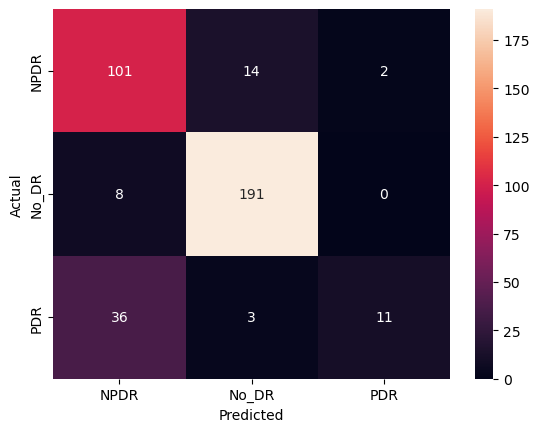

In [99]:
cm = confusion_matrix(true_classes, combined_model_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_test_data, yticklabels= class_labels_test_data)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [100]:
report = classification_report(true_classes, combined_model_pred, target_names=class_labels_test_data)
print(report) 

              precision    recall  f1-score   support

        NPDR       0.70      0.86      0.77       117
       No_DR       0.92      0.96      0.94       199
         PDR       0.85      0.22      0.35        50

    accuracy                           0.83       366
   macro avg       0.82      0.68      0.69       366
weighted avg       0.84      0.83      0.80       366



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

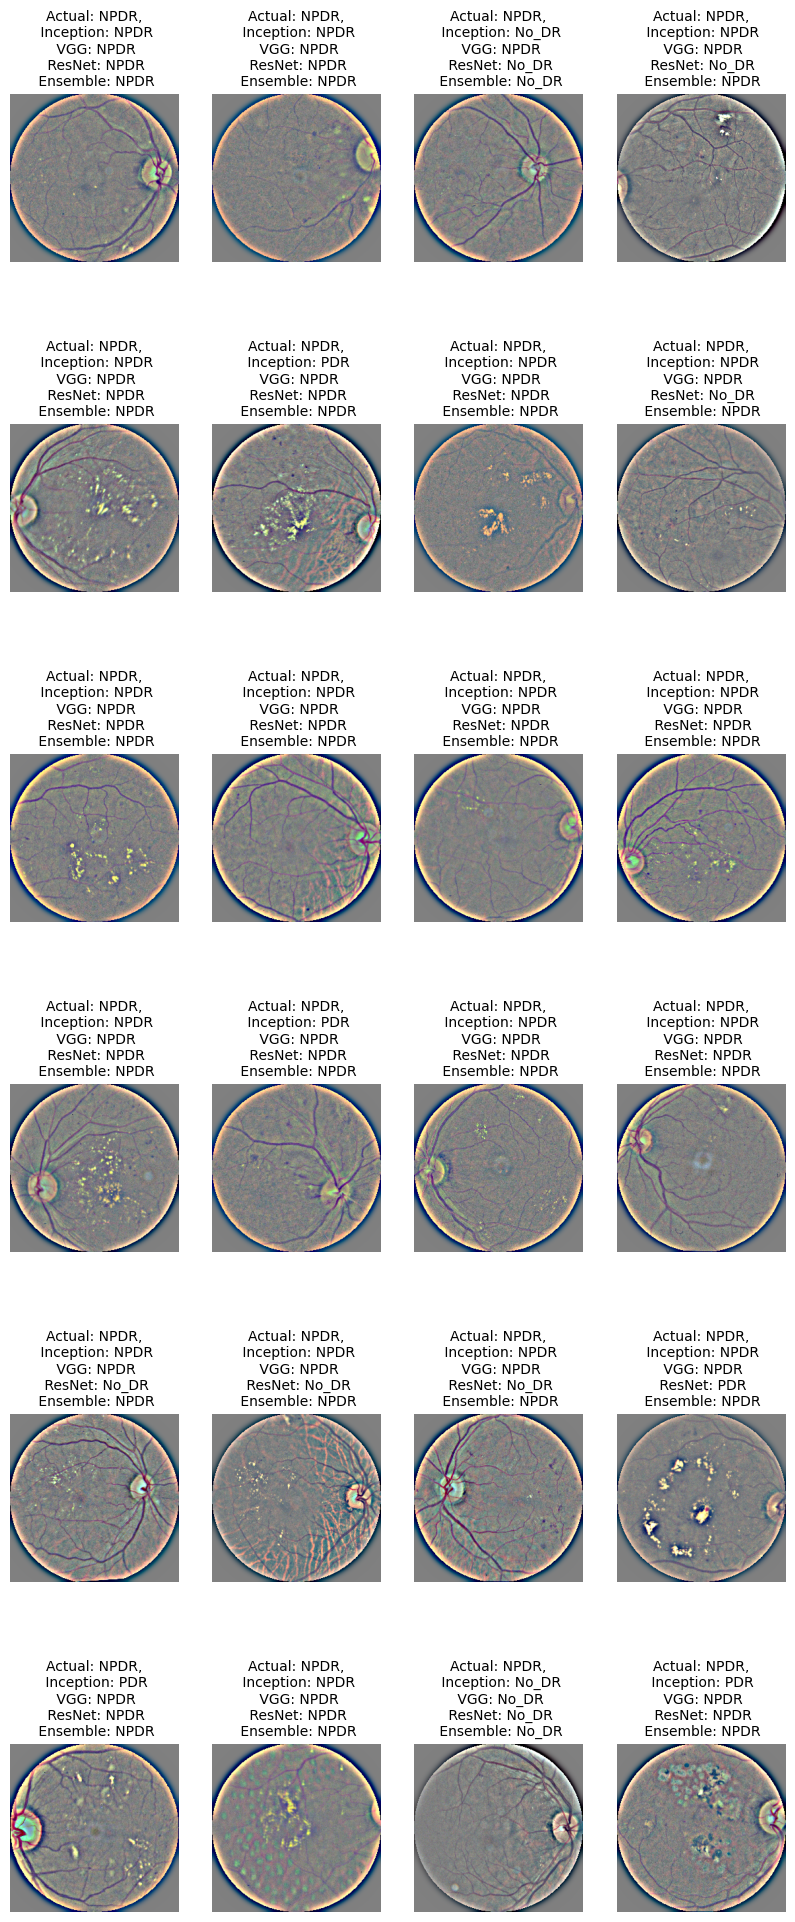

In [101]:
# Get the next batch of images and labels from the generator
images, labels = test_generator.next()

# Display the first 5 images from the batch
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(10, 25))
# +'\n Predicted: {}'.format(class_labels_test_data[predicted_classes[i]]

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title('Actual: {}'.format(class_labels_test_data[int(labels[i])])+',\n Inception: {}'.format(class_labels_test_data[inception_pred[i]])+'\n VGG: {}'.format(class_labels_test_data[vgg_pred[i]])+'\n ResNet: {}'.format(class_labels_test_data[resnet_pred[i]])+'\n Ensemble: {}'.format(class_labels_test_data[combined_model_pred[i]]), fontsize=10)         
    ax.axis('off')

plt.show()

In [102]:
## experiment 
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, concatenate, GlobalMaxPooling2D, Dense, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

In [103]:
# Pre-trained Inception model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

In [104]:
# Freeze the layers of the pre-trained Inception model
for layer in inception_model.layers:
    layer.trainable = False

In [105]:
# Custom block inspired by Google Inception block
conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inception_model.output)
bn1 = BatchNormalization()(conv1)
dropout1 = Dropout(0.2)(bn1)

conv2 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(inception_model.output)
bn2 = BatchNormalization()(conv2)
dropout2 = Dropout(0.2)(bn2)

conv3 = Conv2D(filters=128, kernel_size=(7, 7), activation='relu')(inception_model.output)
bn3 = BatchNormalization()(conv3)
dropout3 = Dropout(0.2)(bn3)

# conv4 = Conv2D(filters=256, kernel_size=(9, 9), activation='relu')(inception_model.output)
# bn4 = BatchNormalization()(conv4)
# dropout4 = Dropout(0.2)(bn4)


# Additional 1x1 convolutional layers for dimension adjustment
conv1x1_1 = Conv2D(filters=128, kernel_size=(4, 4), activation='relu')(dropout1)
resized_conv1 = Conv2D(filters=128, kernel_size=(2, 2), activation='relu')(conv1x1_1)

conv1x1_2 = Conv2D(filters=128, kernel_size=(2, 2), activation='relu')(dropout2)
resized_conv2 = Conv2D(filters=128, kernel_size=(2, 2), activation='relu')(conv1x1_2)


# Concatenate adjusted feature maps
concat = concatenate([resized_conv1, resized_conv2, dropout3])
max_pool = GlobalMaxPooling2D()(concat)

# concat = concatenate([dropout1, dropout2, dropout3, dropout4])
# max_pool = GlobalMaxPooling2D()(concat)

fc = Dense(units=256, activation='relu')(max_pool)
output = Dense(units=5, activation='softmax')(fc)  # Update the units to 5 for five classes

# Combined model
custom_model = Model(inputs=inception_model.input, outputs=output)



# Compile the model
custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [106]:
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_102[0][0]']             
 ormalization)                  )                                                             

 batch_normalization_99 (BatchN  (None, 35, 35, 64)  192         ['conv2d_107[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 35, 35, 64)  192         ['conv2d_109[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 35, 35, 96)  288         ['conv2d_112[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 35, 35, 32)  96          ['conv2d_113[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 35, 35, 64)  192         ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_122 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_125 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_10[0][0]']       
                                                                                                  
 conv2d_136 (Conv2D)            (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_nor

                                                                  'activation_132[0][0]',         
                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_146 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 17, 17, 160)  480        ['conv2d_146[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_14

 batch_normalization_148 (Batch  (None, 17, 17, 160)  480        ['conv2d_156[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 17, 17, 160)  480        ['conv2d_157[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_167 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_158[0][0]']         
                                                                                                  
 batch_normalization_159 (Batch  (None, 17, 17, 192)  576        ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_163 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_159[0][0]']         
          

 activation_167 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_167[0][0]']
                                                                                                  
 conv2d_172 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_176 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 17, 17, 192)  576        ['conv2d_172[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 17, 17, 192)  576        ['conv2d_176[0][0]']             
 Normaliza

 conv2d_186 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_16[0][0]']   
                                                                                                  
 batch_normalization_170 (Batch  (None, 8, 8, 320)   960         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_176[0][0]']
          

                                                                                                  
 activation_182 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_182[0][0]']
                                                                                                  
 activation_185 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 8, 8, 192)   576         ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [107]:
exp_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
#     zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=pre_process
)
exp_train_generator = exp_train_datagen.flow_from_directory(
    train_directory,
#     target_size=(299, 299),
    target_size=(512, 512),
#     batch_size=32,
     batch_size=32,
    class_mode='sparse',
#     color_mode='grayscale',
#     shuffle=True,
    seed=24
)




Found 2930 images belonging to 3 classes.


In [108]:
exp_validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=pre_process
)
exp_validation_generator = exp_validation_datagen.flow_from_directory(
    val_directory,
#     target_size=(299, 299),
    target_size=(512, 512),
    batch_size=32,
    class_mode='sparse',
#     color_mode='grayscale',
    shuffle=False,
    seed=24
)

Found 366 images belonging to 3 classes.


In [109]:
custom_model_h = custom_model.fit(
    exp_train_generator,
    steps_per_epoch=exp_train_generator.samples // exp_train_generator.batch_size,
    epochs=5,
    validation_data = exp_validation_generator,
    validation_steps = exp_validation_generator.samples // exp_validation_generator.batch_size,
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/5
91/91 [==============================] - 2132s 23s/step - loss: 0.6337 - accuracy: 0.7581 - val_loss: 0.7544 - val_accuracy: 0.6733 - lr: 0.0010
Epoch 2/5
91/91 [==============================] - 2178s 24s/step - loss: 0.4640 - accuracy: 0.8054 - val_loss: 0.3824 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 3/5
91/91 [==============================] - 2125s 23s/step - loss: 0.4085 - accuracy: 0.8288 - val_loss: 0.3594 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 4/5
91/91 [==============================] - 1307s 14s/step - loss: 0.4188 - accuracy: 0.8209 - val_loss: 0.3626 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 5/5
91/91 [==============================] - 1147s 13s/step - loss: 0.4039 - accuracy: 0.8320 - val_loss: 0.3662 - val_accuracy: 0.8494 - lr: 0.0010


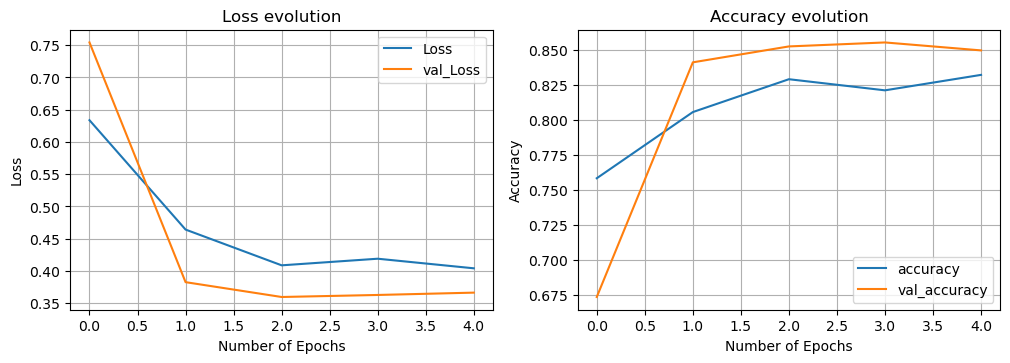

In [110]:
visualize_performance(custom_model_h)

In [111]:
exp_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=pre_process
)

exp_test_generator = exp_test_datagen.flow_from_directory(
    test_directory,
#     target_size=(299, 299),
    target_size=(512, 512),
    batch_size=32,
    class_mode='sparse',
#     color_mode='grayscale',
    shuffle=False,
#     seed=24
)

Found 366 images belonging to 3 classes.


In [112]:
custom_model.evaluate(exp_test_generator)
custom_model_predictions = custom_model.predict(exp_test_generator, steps=exp_test_generator.samples/exp_test_generator.batch_size)
custom_model_predictions


11/11 [==============================] - 104s 9s/step


array([[8.7895173e-01, 6.8861563e-03, 1.1394976e-01, 1.7203754e-04,
        4.0213410e-05],
       [6.5605134e-01, 2.7516761e-01, 6.8163037e-02, 2.5687259e-04,
        3.6108328e-04],
       [7.6990390e-01, 1.7890587e-01, 4.9529612e-02, 7.5939693e-04,
        9.0117339e-04],
       ...,
       [7.2210562e-01, 1.1333069e-02, 2.6624236e-01, 2.2506449e-04,
        9.3950846e-05],
       [6.1147439e-01, 5.2180933e-03, 3.8312632e-01, 1.4814263e-04,
        3.3051718e-05],
       [5.8651388e-01, 2.5330777e-03, 4.1080627e-01, 1.2188679e-04,
        2.4841804e-05]], dtype=float32)

In [113]:

custom_model_predicted_classes = [np.argmax(pred) for pred in custom_model_predictions]
custom_model_predicted_classes[:5]


[0, 0, 0, 0, 0]

In [114]:

exp_true_classes = test_generator.classes
exp_true_classes[:5]


array([0, 0, 0, 0, 0], dtype=int32)

In [115]:

exp_class_labels_test_data = list(exp_test_generator.class_indices.keys())
exp_class_labels_test_data



['NPDR', 'No_DR', 'PDR']

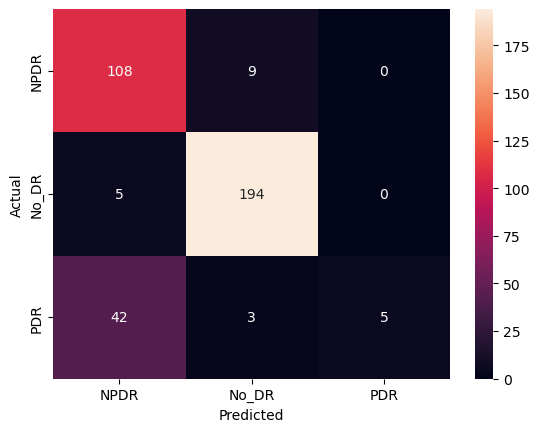

In [116]:

cm = confusion_matrix(true_classes, custom_model_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=exp_class_labels_test_data, yticklabels= exp_class_labels_test_data)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [117]:
report = classification_report(exp_true_classes, custom_model_predicted_classes, target_names=exp_class_labels_test_data)
print(report) 

              precision    recall  f1-score   support

        NPDR       0.70      0.92      0.79       117
       No_DR       0.94      0.97      0.96       199
         PDR       1.00      0.10      0.18        50

    accuracy                           0.84       366
   macro avg       0.88      0.67      0.64       366
weighted avg       0.87      0.84      0.80       366



In [412]:
for layers in ResNet50_model_exp.layers:
    layers.trainable=False

In [413]:
resNet50_model = Sequential()
resNet50_model.add(ResNet50_model_exp)
resNet50_model.add(Dropout(0.25))
resNet50_model.add(Flatten()),
resNet50_model.add(Dropout(0.25))
resNet50_model.add(Dense(128, activation='relu'))
resNet50_model.add(Dense(64, activation='relu'))
resNet50_model.add(Dense(5, activation='softmax'))

In [414]:
resNet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [415]:
resNet50_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 dropout_41 (Dropout)        (None, 16, 16, 2048)      0         
                                                                 
 flatten_16 (Flatten)        (None, 524288)            0         
                                                                 
 dropout_42 (Dropout)        (None, 524288)            0         
                                                                 
 dense_60 (Dense)            (None, 128)               67108992  
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 5)               

In [416]:
custom_resnet_model_h = resNet50_model.fit(
    exp_train_generator,
    steps_per_epoch=exp_train_generator.samples // exp_train_generator.batch_size,
    epochs=5,
    validation_data = exp_validation_generator,
    validation_steps = exp_validation_generator.samples // exp_validation_generator.batch_size,
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/5
91/91 [==============================] - 2563s 28s/step - loss: 31.2235 - accuracy: 0.4010 - val_loss: 4.5645 - val_accuracy: 0.5398 - lr: 0.0010
Epoch 2/5
91/91 [==============================] - 2487s 27s/step - loss: 8.0620 - accuracy: 0.5014 - val_loss: 3.7157 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 3/5
91/91 [==============================] - 2507s 27s/step - loss: 5.1577 - accuracy: 0.5414 - val_loss: 7.1963 - val_accuracy: 0.2983 - lr: 0.0010
Epoch 4/5
91/91 [==============================] - 2593s 28s/step - loss: 6.4977 - accuracy: 0.5390 - val_loss: 4.6605 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 5/5
91/91 [==============================] - 2584s 28s/step - loss: 1.9956 - accuracy: 0.6453 - val_loss: 1.4053 - val_accuracy: 0.6733 - lr: 1.0000e-04


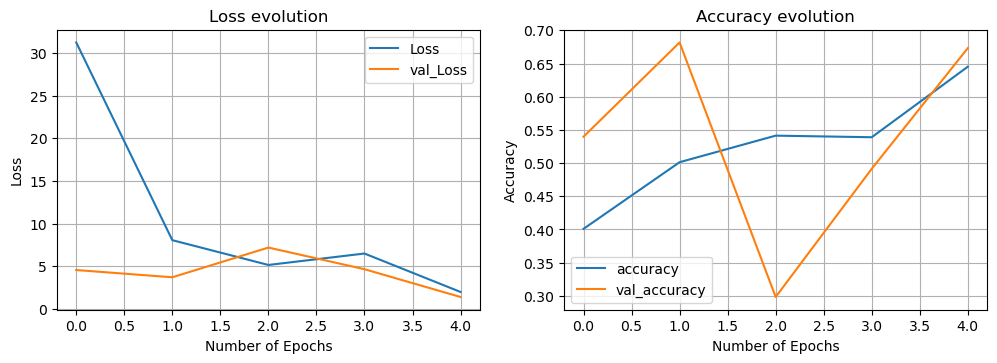

In [417]:
visualize_performance(custom_resnet_model_h)

In [418]:
resNet50_model.evaluate(exp_test_generator)

12/12 [==============================] - 278s 23s/step - loss: 1.4040 - accuracy: 0.6749


[1.4039878845214844, 0.6748633980751038]

In [419]:
# def build_model(optimizer):

# model=Sequential()

# model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))

# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.25))

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy, optimizer= optimizer, metrics=['accuracy'])

# return model

In [420]:
# optimizers = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']

# for i in optimizers:

# model = build_model(i)

# hist=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test,y_test))